### Problem Set 2
#### Joseph Denby

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
import scipy.optimize as opt

In [3]:
incomes = np.loadtxt("../../ProblemSets/PS2/incomes.txt")

## Problem 1 
a). Plot a histogram of percentages of the `income.txt` data with 30 bins. Make sure that the bins are weighted using the `normed=True` option. Make sure your plot has correct x-axis and y-axis labels as well as a plot title.

<IPython.core.display.Javascript object>


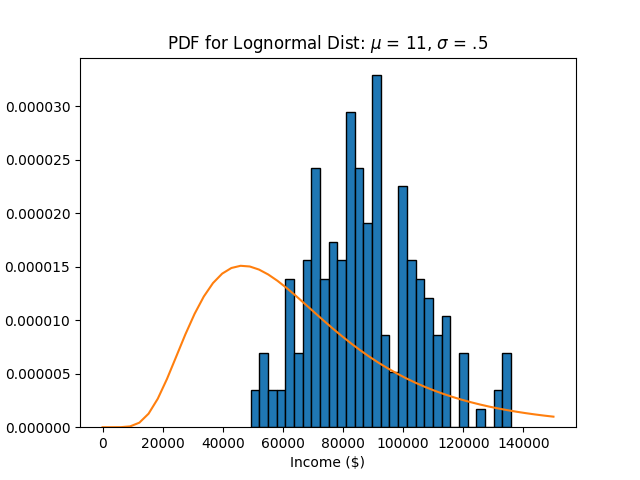

Text(0,0.5,'Percent of respondents')

In [4]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.hist(incomes, 30, edgecolor='black', normed=True)
plt.title('Income Distribution for MACSS Graduate (2018 - 2022)', fontsize=15)
plt.xlabel('Income ($)')
plt.ylabel('Percent of respondents')


b). Plot the lognormal PDF $f(x|\mu = 11.0,\sigma = 0.5)$ for 0 ≤ $x$ ≤ 150,000. What is the value of the log likelihood value for this parameterization of the distribution and given this data?

In [5]:
def lognormpdf(x, mu, sigma):
    pdfvals = (1/(x*sigma*np.sqrt(2*np.pi)))*np.exp(-1 * (((np.log(x)-mu)**2)/(2*sigma**2)))
    return pdfvals

In [6]:
sigma = .5
mu = 11
xvals = np.linspace(.01,150000)
pdfvals = lognormpdf(xvals, mu, sigma)
plt.plot(xvals, pdfvals)
plt.title("PDF for Lognormal Dist: $\mu$ = 11, $\sigma$ = .5")
plt.show()

In [7]:
pdfvals = lognormpdf(incomes, mu, sigma)
ln_pdf_vals = np.log(pdfvals)
log_lik_val = ln_pdf_vals.sum()
print('The log-likelihood for these data with mu = {} and sigma = {}: {} '.format(mu, sigma, log_lik_val))

The log-likelihood for these data with mu = 11 and sigma = 0.5: -2385.856997808558 


c). Estimate the parameters of the lognormal distribution by maximum likelihood and plot its PDF against the PDF from part (b) and the histogram from part (a). Plot the estimated PDF for 0 ≤ $x$ ≤ 150, 000. Report the ML estimates for $\mu$ and $\sigma$, the value of the likelihood function, and the variance-covariance matrix.

First, I'll define a function that takes parameters ($\mu$, $\sigma$, and the $x$ values of interest), and returns the negative log likelihood value for that parameterization.

In [309]:
def log_lik_lognorm(xvals, mu, sigma):
    pdfvals = lognormpdf(xvals, mu, sigma)
    ln_pdf_vals = np.log(pdfvals)
    log_lik_val = ln_pdf_vals.sum()
    return -log_lik_val

Now here's a criterion function that will feed into the optimization function.

In [232]:
def log_norm_criterion(params, xvals):
    mu, sigma = params
    return log_lik_lognorm(xvals, mu, sigma)


Now I can use the `minimize()` function to find the parameterization of the lognormal distribution under which our data are most likely.

In [233]:
mu_init = 11
sigma_init = 2
params_init = np.array([mu_init, sigma_init])
mle_args = incomes
results = opt.minimize(log_norm_criterion, params_init, args = mle_args, method='L-BFGS-B', bounds=((None, None),(0.01, None)))
mu_MLE, sig_MLE = results.x
print('Optimal mu =', mu_MLE, 'Optimal sigma =', sig_MLE)
print('Optimal log-likelihood = ', -log_lik_lognorm(incomes, mu_MLE, sig_MLE))

Optimal mu = 11.425263762200712 Optimal sigma = 0.17883040580292725
Optimal log-likelihood =  -2260.5632562967357


/Users/josephdenby/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/josephdenby/anaconda/lib/python3.6/site-packages/scipy/optimize/optimize.py:643: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


Now we can plot the distribution created by this parameterization against the histogram and initial distribution guess.

In [234]:
count, bins, ignored = plt.hist(incomes, 30, edgecolor='black', normed=True)
plt.title('Income Distribution for MACSS Graduate (2018 - 2022)', fontsize=15)
plt.xlabel('Income ($)')
plt.ylabel('Percent of graduates')
plt.xlim([0, 150000])  

plt.plot(xvals, lognormpdf(xvals, mu, sigma),
         linewidth=2, color='r', label='1: $\mu$=11,$\sigma$=.5')
plt.legend(loc='upper left')

plt.plot(xvals, lognormpdf(xvals, mu_MLE, sig_MLE),
         linewidth=2, color='k', label='2: $\mu$=11.4,$\sigma$=0.18')
plt.legend(loc='upper left')

To get the VCV matrix, 

In [235]:
OffDiagNeg = np.array([[1, -1], [-1, 1]])
vcv_mle = results.hess_inv.todense() * OffDiagNeg
stderr_mu_mle = np.sqrt(vcv_mle[0,0])
stderr_sig_mle = np.sqrt(vcv_mle[1,1])
print('VCV(MLE) = ', vcv_mle)
print('Standard error for mu estimate = ', stderr_mu_mle)
print('Standard error for sigma estimate = ', stderr_sig_mle)

VCV(MLE) =  [[ 0.14748938 -0.08771958]
 [-0.08771958  0.05430559]]
Standard error for mu estimate =  0.38404345728871164
Standard error for sigma estimate =  0.23303560175252208


d). Perform a likelihood ratio test to determine the probability that the data in `incomes.txt` came from the distribution in part (b).

In part (b), we hypothesized that the distribution has $\mu$ = 11 and $\sigma$ = .5.

In [236]:
log_lik_h0 =  -log_lik_lognorm(incomes, 11, .5)
log_lik_mle = -log_lik_lognorm(incomes, mu_MLE, sig_MLE)
LR_val = 2 * (log_lik_mle - log_lik_h0)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 2)
print('chi squared of H0 with 2 degrees of freedom p-value = ', pval_h0)

chi squared of H0 with 2 degrees of freedom p-value =  0.0


So, given the MLE estimate, there is effectively no chance that this null hypothesis is true.

e). With your estimated distribution of incomes for Chicago MACSS students from part (c), you now have a model for what your own income might look like when you graduate. Using that estimated model from part (c), what is the probability that you will earn more than \$100,000? What is the probability that you will earn less than \$75,000?

In [258]:
less75000 = sts.lognorm.cdf(75000, scale = np.exp(mu_MLE), s = sig_MLE)
print(less75000)
more100000 = 1 - sts.lognorm.cdf(100000, scale = np.exp(mu_MLE), s = sig_MLE)
print(more100000)

0.1316784709075322
0.3119980938314615


Based on the model's estimates, one has about a 13% chance of earning less than \$75,000 and a 31% chance of earning more than \$100,000.

## Problem 2
a. Estimate the parameters of the model ($\beta_0$, $\beta_1$, $\beta_2$, $\beta_3$, $\sigma^2$) by maximum likelihood using the fact that each error term $\epsilon_i$ is distributed normally $N(0, \sigma^2)$. Report your estimates, the value of the log likelihood function, and the estimated variance covariance matrix of the estimates.

In [261]:
sickdf = pd.read_csv("../../ProblemSets/PS2/sick.txt")
sick = sickdf['sick']
age = sickdf['age']
children = sickdf['children']
temp = sickdf['avgtemp_winter']

In [285]:
def calculate_error_sum(params, variables):
    b0, b1, b2, b3 = params
    sick, age, children, temp = variables
    errorsum = np.sum((sick - b0 - b1*age - b2*children - b3*temp)**2)
    return errorsum
    

In [286]:
def log_lik_norm(params, variables):
    sick, age, children, temp = variables
    b0, b1, b2, b3, sigma = params
    error_params = (b0, b1, b2, b3)
    errorsum = calculate_error_sum(error_params, variables)
    n = len(sick)
    log_lik_val = -n/2 * np.log(2*np.pi) - n*np.log(sigma) - 1/(2*sigma**2) * errorsum
    #pdfvals = sts.norm.pdf(errors, loc = 0, scale = sigma)
    return -log_lik_val

In [287]:
def log_lik_crit(params, *args):
    sick, age, children, temp = args
    variables = (sick, age, children, temp)
    return log_lik_norm(params, variables)
    

In [300]:
b0_init, b1_init, b2_init, b3_init, sigma_init = (3,3,3,3,2)
params_init = np.array([b0_init, b1_init, b2_init, b3_init, sigma_init])
mle_args = (sick, age, children, temp)
results = opt.minimize(log_lik_crit, params_init, args = mle_args, method='L-BFGS-B', bounds=((None, None),(None, None), (None, None), (None, None),(0.01, None)))
b0_MLE, b1_MLE, b2_MLE, b3_MLE, sig_MLE = results.x
print('Optimal b0 =', b0_MLE, "\nOptimal b1 = ", b1_MLE, "\nOptimal b2 = ", b2_MLE, "\nOptimal b3 = ", b3_MLE, '\nOptimal sigma =', sig_MLE)
print('Optimal log-likelihood = ', -log_lik_norm((b0_MLE, b1_MLE, b2_MLE, b3_MLE, sig_MLE), mle_args))

Optimal b0 = 0.25164471248186654 
Optimal b1 =  0.012933451128921346 
Optimal b2 =  0.40050118094418247 
Optimal b3 =  -0.009991695494457005 
Optimal sigma = 0.01
Optimal log-likelihood =  728.1398814765174


In [299]:
OffDiagNeg = np.array([[1, -1, -1, -1, -1], [-1, 1, -1, -1, -1], [-1, -1, 1, -1, -1], [-1, -1, -1, 1, -1], [-1, -1, -1, -1, 1]])
vcv_mle = results.hess_inv.todense() * OffDiagNeg
stderr_b0_mle = np.sqrt(vcv_mle[0,0])
stderr_b1_mle = np.sqrt(vcv_mle[1,1])
stderr_b2_mle = np.sqrt(vcv_mle[2,2])
stderr_b3_mle = np.sqrt(vcv_mle[3,3])
stderr_sigma_mle = np.sqrt(vcv_mle[4,4])
print('VCV(MLE) = ', vcv_mle)
print('Standard error for b0 = ', stderr_b0_mle)
print('Standard error for b1 = ', stderr_b1_mle)
print('Standard error for b2 = ', stderr_b2_mle)
print('Standard error for b3 = ', stderr_b3_mle)
print('Standard error for sigma estimate = ', stderr_sigma_mle)


VCV(MLE) =  [[ 1.35925086e+03  8.12790429e+01 -5.74108166e+02 -2.64782329e+01
  -5.83723084e+01]
 [ 8.12790429e+01  4.86299871e+00  3.43641152e+01  1.58468272e+00
   3.50215722e+00]
 [-5.74108166e+02  3.43641152e+01  2.42915547e+02 -1.12004406e+01
  -2.49018339e+01]
 [-2.64782329e+01  1.58468272e+00 -1.12004406e+01  5.16474366e-01
  -1.14057927e+00]
 [-5.83723084e+01  3.50215722e+00 -2.49018339e+01 -1.14057927e+00
   4.60424776e+00]]
Standard error for b0 =  36.868019480573324
Standard error for b1 =  2.205220784981976
Standard error for b2 =  15.585748207508102
Standard error for b3 =  0.7186615101942881
Standard error for sigma estimate =  2.145751093896361


b). Use a likelihood ratio test to determine the probability that $\beta_0$ = 1.0, $\sigma^2$ = 0.01 and $\beta_1$ ,$\beta_2$,$\beta_3$ = 0. That is, what is the likelihood that age, number of children, and average winter temperature have no effect on the number of sick days?

In [306]:
(b0_h0, b1_h0, b2_h0, b3_ho, sig_h0) = (1.0, 0, 0, 0, np.sqrt(.01))
log_lik_h0 = -log_lik_norm((b0_h0, b1_h0, b2_h0, b3_ho, sig_h0), mle_args)
log_lik_mle = -log_lik_norm((b0_MLE, b1_MLE, b2_MLE, b3_MLE, sig_MLE), mle_args)
LR_val = 2 * (log_lik_mle - log_lik_h0)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 5)
print('chi squared of H0 with 5 degrees of freedom p-value = ', pval_h0)

chi squared of H0 with 5 degrees of freedom p-value =  0.0


Since there is virtually no chance that the null hypothesis as parameterized above is true given the MLE estimates, we can safely reject the null hypothesis that age, number of children, and average winter temperature have no effect on the number of sick days.